In [339]:
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Extract pre-computed feature vectors from a PyTorch BERT model."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import collections
import logging
import json
import re
import os
import numpy as np
import pandas as pd
import pydicom
import glob
from PIL import Image

import torch
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.modeling import BertModel


class InputExample(object):

    def __init__(self, unique_id, text_a, text_b):
        self.unique_id = unique_id
        self.text_a = text_a
        self.text_b = text_b


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, unique_id, tokens, input_ids, input_mask, input_type_ids):
        self.unique_id = unique_id
        self.tokens = tokens
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.input_type_ids = input_type_ids


def convert_examples_to_features(examples, seq_length, tokenizer):
    """Loads a data file into a list of `InputFeature`s."""

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > seq_length - 2:
                tokens_a = tokens_a[0:(seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids:   0   0  0    0    0     0      0   0    1  1  1   1  1   1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids:   0   0   0   0  0     0   0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = []
        input_type_ids = []
        tokens.append("[CLS]")
        input_type_ids.append(0)
        for token in tokens_a:
            tokens.append(token)
            input_type_ids.append(0)
        tokens.append("[SEP]")
        input_type_ids.append(0)

        if tokens_b:
            for token in tokens_b:
                tokens.append(token)
                input_type_ids.append(1)
            tokens.append("[SEP]")
            input_type_ids.append(1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        while len(input_ids) < seq_length:
            input_ids.append(0)
            input_mask.append(0)
            input_type_ids.append(0)

        assert len(input_ids) == seq_length
        assert len(input_mask) == seq_length
        assert len(input_type_ids) == seq_length

        features.append(
            InputFeatures(
                unique_id=example.unique_id,
                tokens=tokens,
                input_ids=input_ids,
                input_mask=input_mask,
                input_type_ids=input_type_ids))
    return features


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()


def read_examples(input_file):
    """Read a list of `InputExample`s from an input file."""
    examples = []
    unique_id = 0
    with open(input_file, "r", encoding='utf-8') as reader:
        while True:
            line = reader.readline()
            if not line:
                break
            line = line.strip()
            text_a = None
            text_b = None
            m = re.match(r"^(.*) \|\|\| (.*)$", line)
            if m is None:
                text_a = line
            else:
                text_a = m.group(1)
                text_b = m.group(2)
            examples.append(
                InputExample(unique_id=unique_id, text_a=text_a, text_b=text_b))
            unique_id += 1
    return examples


def read_labels(input_file):
    with open(input_file) as f:
        labels = []
        for line in f:
            labels.append(float(line.strip('\n')))
        return labels


def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f


def images_path(path_to_img_folder, patient_name):
    path = os.path.join(path_to_img_folder, patient_name)
    mod_list = list(listdir_nohidden(path))  # TODO: handle several modalities
    filelist = list(listdir_nohidden(os.path.join(path, mod_list[0])))
    filelist = sorted(filelist, key=lambda x: int(x[1:]))
    for file in filelist:
        yield glob.glob(os.path.join(path_to_img_folder,
                        patient_name, mod_list[0], file))[0]


def read_image(path_to_image_file):
    p_array = np.array(pydicom.dcmread(path_to_image_file).pixel_array)
    pil_img = Image.fromarray(p_array)
    pil_img = pil_img.resize((128, 128))
    p_array = np.array(pil_img)
    p_array = p_array / p_array.max()
    return p_array


# TODO: Eliminate of bones
def stack_images(path_to_img_folder, patient_name):
    image = []
    for img_path in images_path(path_to_img_folder, patient_name):
        image.append(read_image(img_path))
    img_np = np.array(image)
    img_np = img_np[img_np.shape[0] - 152:, :, :]
#     img_np = np.transpose(img_np, (1,2,0))
    img_tensor = torch.tensor(img_np, dtype=torch.float)
    return torch.unsqueeze(img_tensor, 0)


class BertFeaturesDataset(Dataset):
    """
    Parameters
    ----------
    input_file : str
        Path to input file with strings
    bert_model : str
        Bert pre-trained model selected in the list: bert-base-uncased,
        bert-large-uncased, bert-base-cased, bert-base-multilingual,
        bert-base-chinese.
    """

    def __init__(self, imgs_folder, input_text_file, labels_file, bert_model,
                 max_seq_length=256, batch_size=4):

        self.imgs_folder = imgs_folder
        self.input_file = input_text_file
        self.labels_file = labels_file
        self.bert_model = bert_model
        self.max_seq_length = max_seq_length
        self.batch_size = batch_size

        self.tensor_dataset = self.init_bert_dataset(
            self.input_file, self.labels_file,
            self.bert_model, self.max_seq_length
        )
        self.dataset = self.get_bert_embeddings(self.tensor_dataset,
                                                self.bert_model,
                                                self.batch_size)
        df = pd.read_csv(self.labels_file, header=None, dtype={0: str, 1: int})
        self.labels = df.iloc[:, 1].values
        self.names = df.iloc[:, 0].to_list()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        name = self.names[idx]
        img = stack_images(self.imgs_folder, name)

        sample = {
            'image': img,
            'embedding': self.dataset[idx][0],
            'label': self.labels[idx],
            'name': self.names[idx]
        }
        return sample

    def init_bert_dataset(self, input_file, labels_file, bert_model,
                          max_seq_length):

        tokenizer = BertTokenizer.from_pretrained(
            bert_model, do_lower_case=True
        )
        examples = read_examples(input_file)
        features = convert_examples_to_features(
            examples=examples, seq_length=max_seq_length, tokenizer=tokenizer
        )

        self.all_input_ids = torch.tensor(
            [f.input_ids for f in features], dtype=torch.long
        )
        self.all_input_mask = torch.tensor(
            [f.input_mask for f in features], dtype=torch.long
        )
        self.all_example_index = torch.arange(
            self.all_input_ids.size(0), dtype=torch.long
        )
        return TensorDataset(self.all_input_ids,
                             self.all_input_mask,
                             self.all_example_index)

    def get_bert_embeddings(self, tensor_dataset, bert_model, batch_size):

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        n_gpu = torch.cuda.device_count()
        model = BertModel.from_pretrained(bert_model)
        model.to(device)
        if n_gpu > 1:
            model = torch.nn.DataParallel(model)

        sampler = SequentialSampler(tensor_dataset)
        dataloader = DataLoader(tensor_dataset, sampler=sampler,
                                batch_size=self.batch_size)

        embedding_dataset = []
        with torch.no_grad():
            for inp_id, inp_mask, ex_index in dataloader:
                layers, _ = model(inp_id, token_type_ids=None,
                                  attention_mask=inp_mask)
                stack_last_4_layers = torch.stack(layers[-4:])
                embedding = torch.sum(stack_last_4_layers, dim=0)
                embedding_dataset.append(embedding)

        return TensorDataset(torch.cat(embedding_dataset, dim=0))



In [249]:
path_to_img_folder = '../../brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/'

In [250]:
bert = BertFeaturesDataset(path_to_img_folder, 'annotations_eng.txt', 'brain-labels.csv', 'bert-base-uncased')
from torch.utils.data import SequentialSampler
sampler = SequentialSampler(bert)

In [340]:
dl = DataLoader(bert, sampler=sampler, batch_size=2)

In [341]:
img = next(iter(dl))['image']

In [342]:
img

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           

In [343]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [344]:
%memit img

peak memory: 248.35 MiB, increment: 0.13 MiB


In [345]:
img.shape

torch.Size([2, 1, 152, 128, 128])

In [332]:
from pytorch_modelsize import SizeEstimator

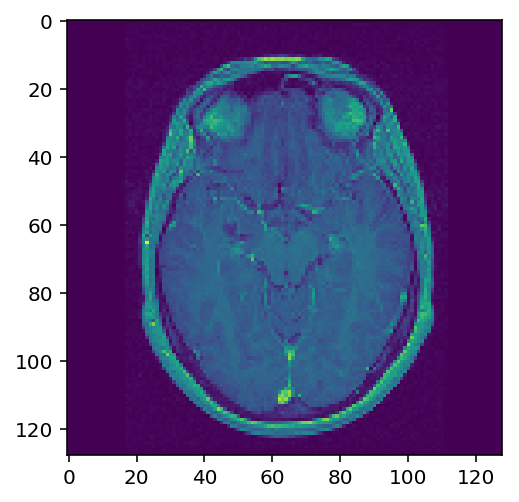

In [346]:
plt.imshow((img[0][0][60].numpy()))

In [247]:
next(iter(dl))['image']

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           

In [178]:
import matplotlib.pyplot as plt
img = bert[2]['image']
img = img[:,:,img.shape[2]-152:]

In [232]:
bert[2]['image'].shape

torch.Size([256, 256, 152])

In [239]:
torch.unsqueeze(bert[2]['image'], 0).shape


torch.Size([1, 152, 256, 256])

In [206]:
bert[0]['embedding']

(tensor([[-0.6643, -4.3683, -0.8529,  ..., -0.2001,  0.5041,  3.5901],
         [-0.7617,  2.7280,  2.0050,  ..., -1.5928,  1.6329,  0.6991],
         [ 1.3113, -0.7577,  3.5449,  ..., -1.8577,  0.8924,  1.7874],
         ...,
         [-0.4364, -0.2560,  1.1974,  ..., -0.5245, -3.5708, -2.8485],
         [-1.6217, -1.6692, -0.8874,  ..., -1.9156,  0.5370,  0.6046],
         [ 0.2860,  0.4365,  0.6367,  ...,  0.8518, -0.7424, -0.5542]]),)

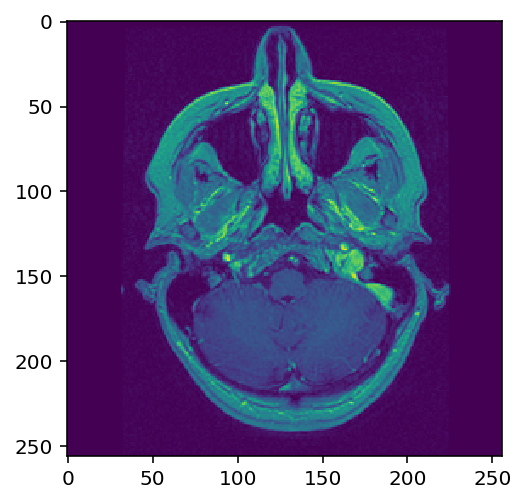

In [177]:
plt.imshow(img)

In [157]:
np.transpose(arr, (1,2,0)).shape

(256, 256, 180)

In [154]:
np.rollaxis(arr, 2, 0).shape

(256, 180, 256)

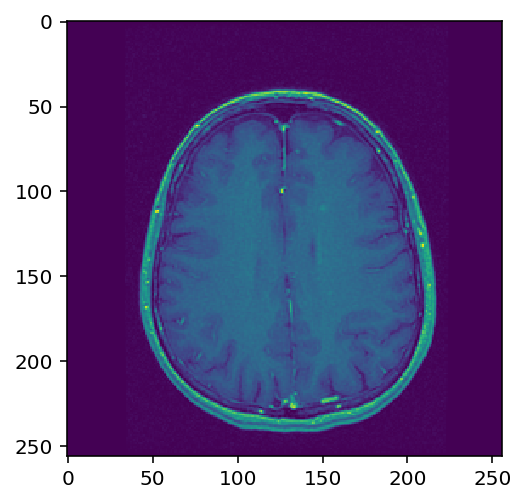

In [159]:
plt.imshow(np.transpose(arr, (1,2,0))[:,:,120])

In [132]:
img = img/img.max()

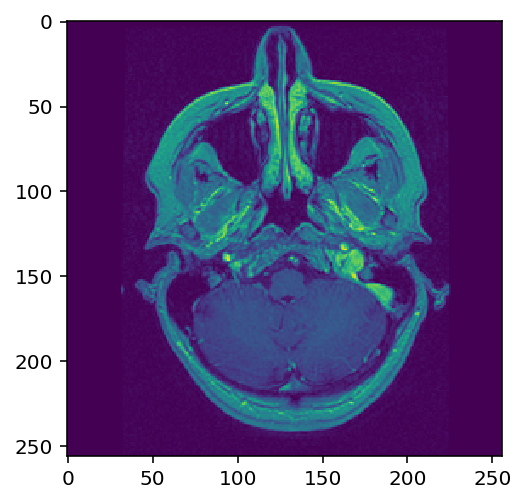

In [133]:
plt.imshow(img)

In [347]:
import torch.nn.functional as F

In [ ]:
F.pad()